In [1]:
# %matplotlib inline

import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Fetch Data

Each of the batch files in the dataset contains a **dictionary** with the following elements:

* **data**: a 10,000 x 3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.<br><br>

* **labels**: a list of 10,000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

Additionally, it includes a `batches.meta` file, which contains:

* **label_names**: a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, `label_names[0]=="airplane"`, `label_names[1]=="automobile"`, etc.

### Clean Data

Data cleaning is imoprtatnt to minimize error, specially when it comes to overfitting. Some strategies are:

1. If you have an image in color, convert it to grayscale to lower the dimensionality of the input data, and consequently lower the number of parameters.<br><br>

2. Also, consider center-cropping the image, since edges of an image may not provide useful information.<br><br>

3. The input should also be normalized by subtracting the mean and dividing by the standard deviation of each data sample so that the gradients during back-propagation don't change too dramatically.

In [2]:
def clean_data(data):
    
    print("Original data: " + str(data.shape))
    
    # the data is now a 32x32 matrix with 3 channels
    all_images = data.reshape(data.shape[0], 3, 32, 32)
    print("> After resizing: " + str(all_images.shape)) # (50000, 3, 32, 32)
    
    # grayscale the image by averaging the color intensities
    grayscale_images = all_images.mean(1)
    print("> After greyscale: " + str(grayscale_images.shape)) # (50000, 32, 32)
    
    # crop the 32x32 image to a 24x24 image
    cropped_images = grayscale_images[:, 4:28, 4:28] # exclude 4 units at the top, bottom, left and right
    print("> After cropping: " + str(cropped_images.shape)) # (50000, 24, 24)
    
    # flattening the 50,000 images into an array
    image_data = cropped_images.reshape(data.shape[0], -1)
    print("> After reshape: " + str(image_data.shape)) # (50000, 576)
    
    image_size = image_data.shape[1] # 576
    
    # get mean of each row and make it (5000, 1) - not (5000,)
    means = np.mean(image_data, axis=1).reshape(len(data), 1)
    
    # get std of each row and make it (5000, 1) - not (5000,)
    stds = np.std(image_data, axis=1).reshape(len(data), 1)
    adj_stds = np.maximum(stds, 1.0/np.sqrt(image_size))
    
    # normalize the pixel values by subtracting the mean and diving by the std
    normalized_images = (image_data - means) / adj_stds
    print("> After normalized: " + str(normalized_images.shape))
    
    return normalized_images

In [3]:
def unpickle(file):
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def read_data(dir_name):
    
    meta_dir = ("{}/batches.meta".format(directory))
    names = unpickle(meta_dir)[b"label_names"]

    # want to collect all batches into a single data and label matrixes
    data, labels = [], []

    # 5 = number of batches
    for i in range(1, 6): # iterate through them

        filename = "{}/data_batch_{}".format(directory, i)

        # for each data batch, unpickle it. we get a dictionary back.
        batch_data = unpickle(filename)

        # if theres already content in the data array
        if len(data) > 0:
            data = np.vstack((data, batch_data[b"data"]))
            labels = np.hstack((labels, batch_data[b"labels"]))
        else:
            data = batch_data[b"data"]
            labels = batch_data[b"labels"]

    data = clean_data(data).astype(np.float32)
            
    return names, data, labels

# Visualize Images

In [5]:
def show_some_examples(names, data, labels):
    
    plt.figure(figsize=(10,10))
    rows, cols = 4, 4 # these are arbitrary
    random_ids = random.sample(range(len(data)), rows*cols) # randomly select the images
    
    for i in range(rows*cols):
        
        plt.subplot(rows, cols, i+1)
        curr_index = random_ids[i]
        plt.title(names[labels[curr_index]])
        
        image = np.reshape(data[curr_index, :], (24, 24))
        # plt.imshow(image, cmap='Greys_r')
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize Filters

In [6]:
# randomly initialize 32 filters. these will be the features/weights
def show_weights(W, filename=None):

    plt.figure(figsize=(10,10))
    
    # define just enough rows and columns to show 32 figures
    rows, cols = 4, 8
    
    # visualize each filter matrix
    for i in range(np.shape(W)[3]): # 0 to 31

        image = W[:, :, 0, i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    
    plt.show()

# Convolve Using Filters

In [7]:
def show_conv_results(data, filename=None):
    
    plt.figure(figsize=(10,10))
    rows, cols = 4, 8
    
    for i in range(np.shape(data)[3]):
        image = data[0, :, :, i] # [1, 24, 24, 32]
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    
    plt.show()

# Max-pooling

# Implementation

### Fetch and Clean Data

In [8]:
directory = "./cfar10"

# read and clean the data
names, data, labels = read_data(directory) 

Original data: (50000, 3072)
> After resizing: (50000, 3, 32, 32)
> After greyscale: (50000, 32, 32)
> After cropping: (50000, 24, 24)
> After reshape: (50000, 576)
> After normalized: (50000, 576)


### Visualize Images

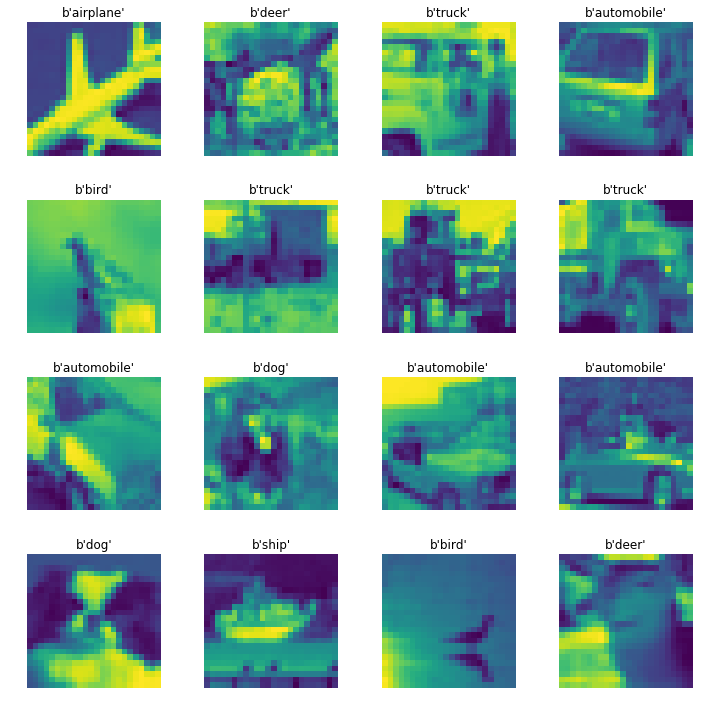

In [9]:
show_some_examples(names, data, labels)

### Visualize Filters

We will convolve an image with a couple of random 5x5: a filter.

Filters are a way to extract useful image features such as edges and shapes. With these features, we can train a machine learning model on them. The more filters we use on an image, the greater the dimension of the feature vector.

In [10]:
# # define the tensor representing the random filters
# W = tf.Variable(tf.random_normal([5, 5, 1, 32]))

# with tf.Session() as sess:
    
#     sess.run(tf.global_variables_initializer())
#     W_val = sess.run(W)
#     show_weights(W_val)

### Convolve Using Filters

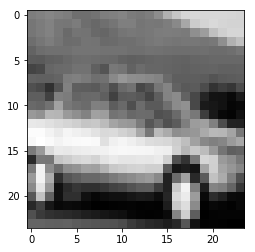

In [11]:
# visualizing convolution

raw_data = data[4, :] # get an image from the dataset
raw_image = np.reshape(raw_data, (24, 24)) 
plt.figure()
plt.imshow(raw_image, cmap='Greys_r')
plt.show()

Use Tensorflow's convolve function on the randomly generated filters.

By adding a bias term and an activation function (such as relu), the convolution layer of the network behaves nonlinearly, which improves its expressiveness. After adding a bias term and an activation function, the resulting convolutions can capture more powerful patterns within images.

In [12]:
def conv_layer(x, W, bias):
    
    # given an image x, apply all the filters W to it
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') # strides=[batch, height, width, channels]
    # note: the padding determines what to do when the window runs out of pixels at the end
    conv_with_bias = tf.nn.bias_add(conv, bias)
    conv_out = tf.nn.relu(conv_with_bias)

    return conv_out

In [13]:
# # define the input tensor for the 24x24 image
# x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])

# # define the filters and corresponding parameters
# bias = tf.Variable(tf.random_normal([32])) # of length/shape = 32

# # given an image x, apply all the filters W to it
# conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') # strides=[batch, height, width, channels]
# conv_with_bias = tf.nn.bias_add(conv, bias)
# conv_out = tf.nn.relu(conv_with_bias)

# with tf.Session() as sess:
    
#     sess.run(tf.global_variables_initializer())
    
#     conv_val = sess.run(conv)
#     print((conv_val).shape)
#     show_conv_results(conv_val)
    
#     conv_out_val = sess.run(conv_out)
#     print((conv_val).shape)
#     show_conv_results(conv_out_val)

### Max-pooling

This is done to reduce the size of the convolved outputs. By rescaling/subsampling the output, we can reduce the number of parameters - which helps avoid overfitting the data.

In max-pooling, a window is passed across an image. At each location it stops, it picks the pixel with the maximum value. Depending on the length of the stride, the resulting image is a fraction of the size of the original - but keeps its most relevant features.

This lessens the dimentionality of the data, this lowering the number of parameters in future steps.

In [14]:
def max_pool_layer(conv, k=2):
    
    # k: # window size
    # strides: steps taken to move across the image
    return (tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME'))

In [15]:
# kernel_size = 2 
# max_pool = max_pool_layer(conv_out, kernel_size)

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     max_pool_val = sess.run(max_pool)
#     print(max_pool_val.shape) # the images are now (12,12) - their size was halved
#     show_conv_results(max_pool_val) # shown: lower-resolution convolved outputs

### Convolutional Neural Network

In [16]:
# define the input and output placeholders
x = tf.placeholder(tf.float32, [None, 24 * 24])
y = tf.placeholder(tf.float32, [None, len(names)]) # len(names) = number of classes

# apply 64 convolutions of window-size 5x5
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64])) # want 64 filters (1 -> greyscale)
b1 = tf.Variable(tf.random_normal([64]))
# at this point, we have 64 images

# apply 64 more convolutions of window-size 5x5
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64]))
b2 = tf.Variable(tf.random_normal([64]))

# introduce a fully-connected layer - need to flatten the feature map to shape [batch_size, features]
# at this point, we will have maxpooled twice. image size: 24x24 -> 12x12 -> 6x6
# 64 is the number of channels.
W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024])) # 1024 is the number of perceptrons in this layer

# define the variables for a fully-connected layer
W_out = tf.Variable(tf.random_normal([1024, len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

In [17]:
def model():
    
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    
    # construct the first layer of convolution and maxpooling
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = max_pool_layer(conv_out1)
    
    # normalizing to "prevent neurons from saturating when inputs may have varying scale, and to aid generalization."
    norm1 = tf.nn.local_response_normalization(maxpool_out1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

    # construct the second layer
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.local_response_normalization(conv_out2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    maxpool_out2 = max_pool_layer(norm2)

    # construct the fully connected layers
    # first, flatten the images. instead of (6,6,64), now 6*6*64 = 2304
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)

    out = tf.add(tf.matmul(local_out, W_out), b_out)

    return out

In [18]:
model_op = model()

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
train_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

total_batches = 200
epochs = 1

# loop through the dataset of images in small batches
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    
    batch_size = len(data)//total_batches
    print('batch_size: ', batch_size)
    
    for j in range(0, epochs):
        
        print('EPOCH ', j+1)
        
        # train the network in batches
        for i in range(0, len(data), batch_size):
            
            batch_data = data[i: i+batch_size, :]
            batch_onehot_vals = onehot_vals[i: i+batch_size, :]
            
            _, accuracy_val = sess.run([train_optimizer, accuracy], feed_dict={x:batch_data, y:batch_onehot_vals})
            
            if i % 1000 == 0:
                print(i, accuracy_val)
                
        print('DONE WITH EPOCH')

Instructions for updating:
Use `argmax` instead
batch_size:  250
EPOCH  1
0 0.092
1000 0.14
2000 0.092
3000 0.148
4000 0.148
5000 0.136
6000 0.168
7000 0.156
8000 0.208
9000 0.168
10000 0.176
11000 0.176
12000 0.184
13000 0.18
14000 0.16
15000 0.176
16000 0.192
17000 0.172
18000 0.204
19000 0.184
20000 0.224
21000 0.184
22000 0.18
23000 0.188
24000 0.208
25000 0.208
26000 0.208
27000 0.224


KeyboardInterrupt: 

# Optimization Tips

* **Augment data**: From a single image, you can easily generate new training images. As a start, just flip an image horizontally or vertically and you can quadruple your dataset size. You may also adjust the brightness of the image or the hue to ensure the neural network generalizes to other fluctuations. Lastly, you may even want to add random noise to the image to make the classifier robot to small occlusions.<br><br>

* **Early stopping**: Keep track of the training and testing error while you train the neural network. At first, both errors should slowly dwindle down, because the network is learning. But sometimes, the test error goes back up. This is a signal that the neural network has started overfitting on the training data, and is unable to generalize to previously unseen input. You should stop the training the moment you witness this phenomenon.<br><br>

* **Regularize weights**: Another way to combat overfitting is by adding a regularization term to the cost function. We’ve already seen regularization in previous chapters, and the same concepts apply here.<br><br>

* **Dropout**: TensorFlow comes with a handy function tf.nn.dropout, which can be applied to any layer of the network to reduce overfitting. It turns off a randomly selected number of neurons in that layer during training so that the network must be redundant and robust to inferring output.<br><br>

* **Deeper**: A deeper architecture means adding more hidden layers to the neural network. If you have enough training data, it’s been shown that adding more hidden layers improves performance.<br><br>